<a href="https://colab.research.google.com/github/Nathan-Levy/Traffic-Flow-Prediction-in-Urban-Areas/blob/main/Dens_Park_Traffic_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from keras import layers

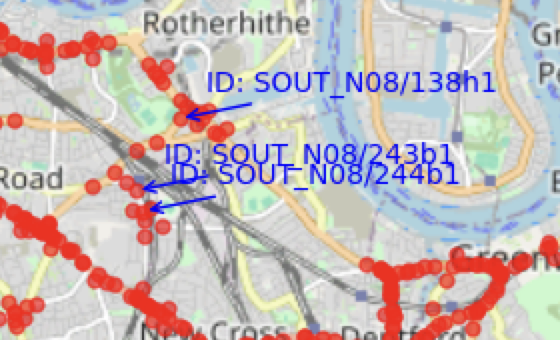

In [2]:
Dens = pd.read_csv('Dens.csv')

In [3]:
Dens.dropna(how='all', inplace=True)

In [4]:
Dens['day'] = pd.to_datetime(Dens['day'])

Dens['datetime'] = Dens['day'] + pd.to_timedelta(Dens['interval'], unit='s')

Dens.set_index("datetime", inplace=True)

# Keep only the relevant column
time_flow = Dens[['SOUT_N08/138h1 flow', 'SOUT_N08/243b1 flow', 'SOUT_N08/244b1 flow']]

print(time_flow)

                     SOUT_N08/138h1 flow  SOUT_N08/243b1 flow  \
datetime                                                        
2015-09-25 00:00:00            135.00000             90.00000   
2015-09-25 00:05:00             45.00000            120.00000   
2015-09-25 00:10:00            132.00000            156.00000   
2015-09-25 00:15:00            120.00000            225.00000   
2015-09-25 00:20:00             60.00000             75.00000   
...                                  ...                  ...   
2015-10-01 23:35:00            134.57142            207.42858   
2015-10-01 23:40:00             90.00000            195.00000   
2015-10-01 23:45:00             72.00000            180.00000   
2015-10-01 23:50:00             30.00000            165.00000   
2015-10-01 23:55:00             45.00000             75.00000   

                     SOUT_N08/244b1 flow  
datetime                                  
2015-09-25 00:00:00             75.00000  
2015-09-25 00:05:00      

<ipython-input-4-86530d2861d8>:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  Dens['day'] = pd.to_datetime(Dens['day'])


In [5]:
# Normalise
scaler = MinMaxScaler()
flow_normalised = scaler.fit_transform(time_flow)

In [6]:
# Train and validation split
train = len(flow_normalised)*0.8
X_train, X_val, = flow_normalised[:int(train), :], flow_normalised[int(train):, :]

In [7]:
def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 3
X_train, y_train = create_dataset(X_train, look_back)
X_val, y_val = create_dataset(X_val, look_back)

In [8]:
# [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

In [9]:
input_layer = keras.layers.Input(shape=(look_back, 3))
encoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = keras.layers.LSTM(32, activation='relu', return_sequences=False)(encoded)

# Decoder
decoded = keras.layers.RepeatVector(look_back)(encoded)
decoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = keras.layers.TimeDistributed(layers.Dense(3, activation='linear'))(decoded)

# Autoencoder Model
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3, 3)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 3, 64)               │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 3, 64)               │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 3, 3)                │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,851 (214.26 KB)

 Trainable params: 54,851 (214.26 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, validation_data=[X_val, X_val])

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.1221 - val_loss: 0.0373
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0288 - val_loss: 0.0216
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0137 - val_loss: 0.0128
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0088 - val_loss: 0.0116
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0080 - val_loss: 0.0109
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0070 - val_loss: 0.0097
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0063 - val_loss: 0.0092
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0059 - val_loss: 0.0086
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0057 - val_loss: 0.0085
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0054 - val_loss: 0.0083
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0055 - val_loss: 0.0081
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0

In [11]:
# Extract the encoder model
encoder = keras.models.Model(inputs=input_layer, outputs=encoded)

# Generate the encoded features
encoded_features = encoder.predict(X_train)
encoded_features_val = encoder.predict(X_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [12]:
# Define the prediction model
prediction_model = keras.models.Sequential()
prediction_model.add(keras.layers.Dense(16, activation='relu', input_dim=encoded_features.shape[1]))
prediction_model.add(keras.layers.Dense(8, activation='relu'))
prediction_model.add(keras.layers.Dense(3, activation='linear'))

# Compile the prediction model
prediction_model.compile(optimizer='adam', loss='mse')

# Train the prediction model
prediction_model.fit(encoded_features, y_train, epochs=20, validation_data=(encoded_features_val, y_val))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0286 - val_loss: 0.0152
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 - val_loss: 0.0145
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0141
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - val_loss: 0.0140
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0140
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104 - val_loss: 0.0144
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0139
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0139
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0137
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - val_loss: 0.0137
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0137
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0136


In [13]:
# Use the prediction model to make predictions
y_pred = prediction_model.predict(encoded_features_val)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [14]:
temp_val_1 = np.zeros((y_val.shape[0], 3))
temp_pred_1 = np.zeros((y_pred.shape[0], 3))

temp_val_1[:, 0] = y_val[:, 0]
temp_pred_1[:, 0] = y_pred[:, 0]

y_val_detector_1 = temp_val_1[:, 0]
y_pred_detector_1 = temp_pred_1[:, 0]

In [15]:
temp_val_2 = np.zeros((y_val.shape[0], 3))
temp_pred_2 = np.zeros((y_pred.shape[0], 3))

temp_val_2[:, 1] = y_val[:, 1]
temp_pred_2[:, 1] = y_pred[:, 1]

y_val_detector_2 = temp_val_2[:, 1]
y_pred_detector_2 = temp_pred_2[:, 1]

In [16]:
temp_val_3 = np.zeros((y_val.shape[0], 3))
temp_pred_3 = np.zeros((y_pred.shape[0], 3))

temp_val_3[:, 2] = y_val[:, 2]
temp_pred_3[:, 2] = y_pred[:, 2]

y_val_detector_3 = temp_val_3[:, 2]
y_pred_detector_3 = temp_pred_3[:, 2]

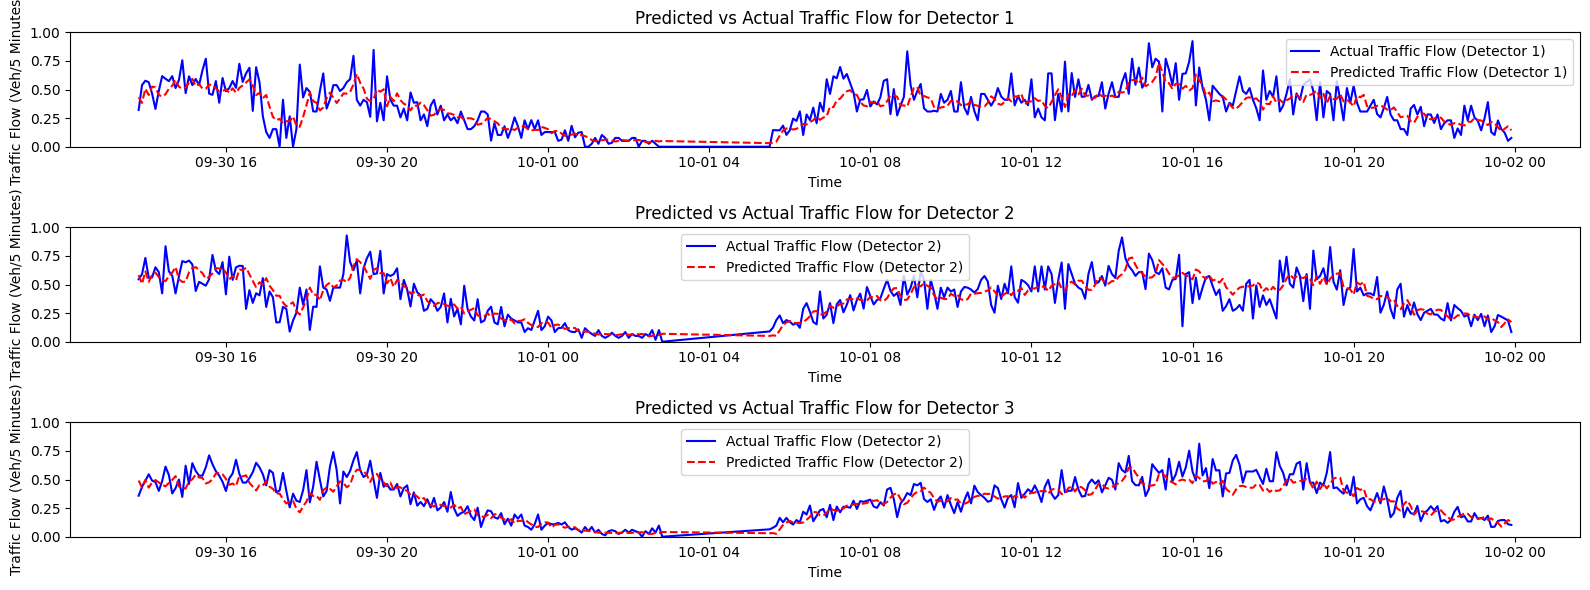

In [17]:
import matplotlib.pyplot as plt

timestamps = time_flow.index[-len(y_val):]

# Define figure and axes for side-by-side plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 6))  # 3 rows, 1 column

# First plot on ax1 (Actual vs Predicted for Detector 1)
ax1.plot(timestamps, y_val_detector_1, label='Actual Traffic Flow (Detector 1)', color='blue')
ax1.plot(timestamps, y_pred_detector_1, label='Predicted Traffic Flow (Detector 1)', color='red', linestyle='--')
ax1.set_xlabel('Time')
ax1.set_ylabel('Traffic Flow (Veh/5 Minutes)')
ax1.set_title('Predicted vs Actual Traffic Flow for Detector 1')
ax1.legend()

# Second plot on ax2 (Actual vs Predicted for Detector 2)
ax2.plot(timestamps, y_val_detector_2, label='Actual Traffic Flow (Detector 2)', color='blue')
ax2.plot(timestamps, y_pred_detector_2, label='Predicted Traffic Flow (Detector 2)', color='red', linestyle='--')
ax2.set_xlabel('Time')
ax2.set_ylabel('Traffic Flow (Veh/5 Minutes)')
ax2.set_title('Predicted vs Actual Traffic Flow for Detector 2')
ax2.legend()

# Third plot on ax3 (Actual vs Predicted for Detector 3)
ax3.plot(timestamps, y_val_detector_3, label='Actual Traffic Flow (Detector 2)', color='blue')
ax3.plot(timestamps, y_pred_detector_3, label='Predicted Traffic Flow (Detector 2)', color='red', linestyle='--')
ax3.set_xlabel('Time')
ax3.set_ylabel('Traffic Flow (Veh/5 Minutes)')
ax3.set_title('Predicted vs Actual Traffic Flow for Detector 3')
ax3.legend()

# # Set the y-axis limits for both plots
ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


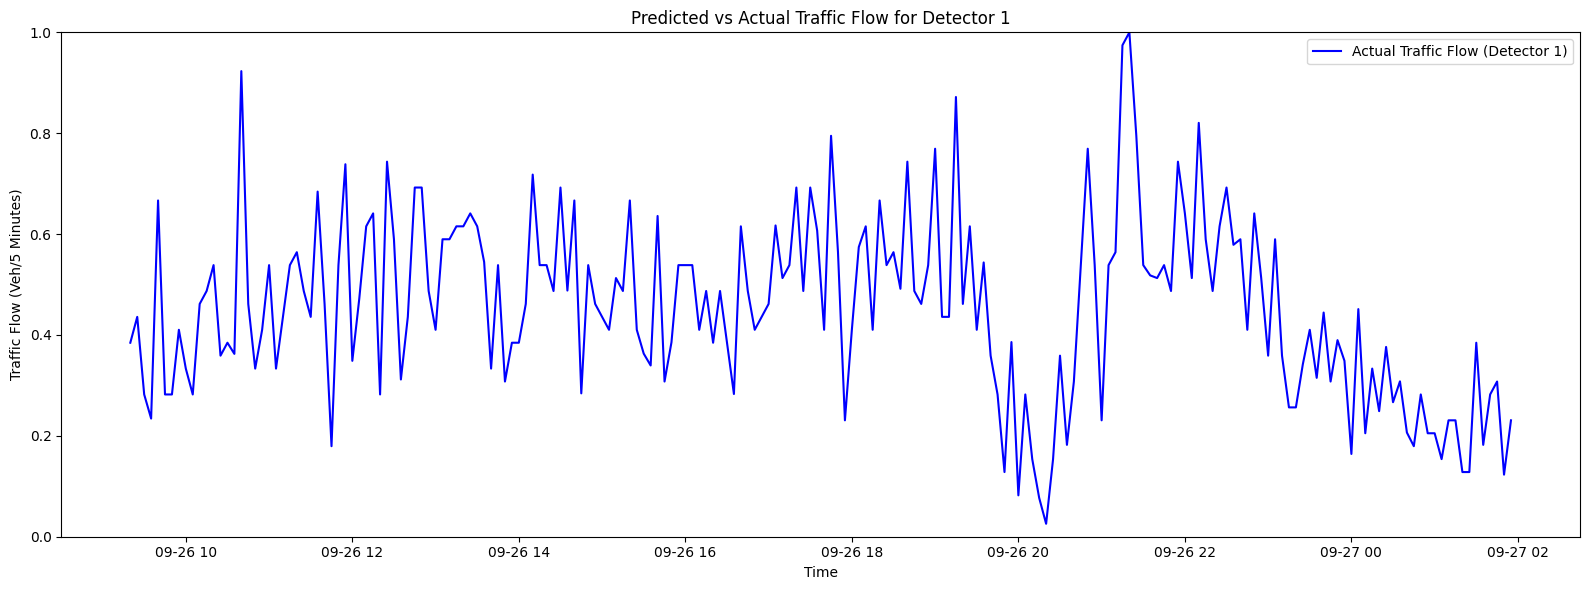

In [42]:
# Define figure and axes for side-by-side plots
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 6))  # 3 rows, 1 column

timestamps = time_flow.index[:]

# First plot on ax1 (Actual vs Predicted for Detector 1)
ax1.plot(timestamps[400:600], [row[0] for row in flow_normalised[400:600]], label='Actual Traffic Flow (Detector 1)', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Traffic Flow (Veh/5 Minutes)')
ax1.set_title('Predicted vs Actual Traffic Flow for Detector 1')
ax1.legend()

# # Set the y-axis limits for both plots
ax1.set_ylim(0, 1)


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

In [38]:
  print([row[0] for row in flow_normalised[250:800:5]])

[0.2564102564102564, 0.5128205128205128, 0.28205128205128205, 0.15384615384615385, 0.2564102564102564, 0.3333333333333333, 0.1282051282051282, 0.3333333333333333, 0.20512820512820512, 0.26634384615384615, 0.1282051282051282, 0.15384615384615385, 0.1282051282051282, 0.07692307692307693, 0.1794871794871795, 0.10256410256410256, 0.15384615384615385, 0.05128205128205128, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.15738286324786324, 0.23076923076923078, 0.1282051282051282, 0.15384615384615385, 0.14358974358974358, 0.36992611965811967, 0.1641025641025641, 0.358974358974359, 0.3076923076923077, 0.38461538461538464, 0.28205128205128205, 0.46153846153846156, 0.3625110683760684, 0.5384615384615384, 0.48717948717948717, 0.5384615384615384, 0.6410256410256411, 0.4358974358974359, 0.5897435897435898, 0.6153846153846154, 0.38461538461538464, 0.5384615384615384, 0.28422423076923076, 0.5128205128205128, 0.3395225641025641, 0.5384615384615384, 0.48717948717948717, 0.41025641025641

In [37]:
print(flow_normalised[250:800:5])

[[0.25641026 0.43918919 0.33970798]
 [0.51282051 0.45608108 0.3033107 ]
 [0.28205128 0.28716216 0.23051613]
 [0.15384615 0.40540541 0.26691341]
 [0.25641026 0.625      0.4367674 ]
 [0.33333333 0.25337838 0.27904584]
 [0.12820513 0.28716216 0.20625127]
 [0.33333333 0.28716216 0.26691341]
 [0.20512821 0.22522523 0.18603056]
 [0.26634385 0.10398943 0.13902352]
 [0.12820513 0.28716216 0.2183837 ]
 [0.15384615 0.18581081 0.10919185]
 [0.12820513 0.16891892 0.12132428]
 [0.07692308 0.06756757 0.07279457]
 [0.17948718 0.10135135 0.04852971]
 [0.1025641  0.08445946 0.06066214]
 [0.15384615 0.13513514 0.07279457]
 [0.05128205 0.05067568 0.03639728]
 [0.07692308 0.06756757 0.06066214]
 [0.07692308 0.01689189 0.02426486]
 [0.07692308 0.08445946 0.12132428]
 [0.15738286 0.23706897 0.13429342]
 [0.23076923 0.27027027 0.20625127]
 [0.12820513 0.18581081 0.10919185]
 [0.15384615 0.11824324 0.15772156]
 [0.14358974 0.10810811 0.09705942]
 [0.36992612 0.18987631 0.11696482]
 [0.16410256 0.24324324 0.19

In [5]:
from folium.plugins import HeatMapWithTime
import folium
import pandas as pd
import numpy as np

# Sample time_flow DataFrame
# Ensure that your actual DataFrame has a timestamp index and valid flow data
time_flow = pd.DataFrame({
    "SOUT_N08/138h1 Flow": time_flow['SOUT_N08/138h1 flow'].tolist(),
    "SOUT_N08/243b1 Flow": time_flow['SOUT_N08/243b1 flow'].tolist(),
    "SOUT_N08/244b1 Flow": time_flow['SOUT_N08/244b1 flow'].tolist()
}, index=pd.date_range("2015-09-25", periods=1909, freq="5T"))

detector_locations = {
    "SOUT_N08/138h1": (51.492815, -0.04943),
    "SOUT_N08/243b1": (51.4872033, -0.0548335),
    "SOUT_N08/244b1": (51.4855977, -0.0539588)
}

# Normalize flow values
# max_flow = time_flow.max().max()
# time_flow = time_flow / max_flow  # Scale between 0-1

# Prepare Heatmap Data
heatmap_data = []
for timestamp, row in time_flow.iterrows():
    time_slot = []
    for column, flow_value in row.items():
        detector_id = column.split()[0]
        if detector_id in detector_locations:
            lat, lon = detector_locations[detector_id]
            time_slot.append([lat, lon, flow_value])
    heatmap_data.append(time_slot)

# Flatten the data
flattened_data = []
for timestamp, time_slot in zip(time_flow.index, heatmap_data):
    for lat, lon, weight in time_slot:
        flattened_data.append([timestamp, lat, lon, weight])

# Create DataFrame
df_heatmap = pd.DataFrame(flattened_data, columns=["Timestamp", "Latitude", "Longitude", "Weight"])

# Convert Timestamp to datetime and sort
df_heatmap['Timestamp'] = pd.to_datetime(df_heatmap['Timestamp'])
df_heatmap = df_heatmap.sort_values(by="Timestamp")

# Prepare data for HeatMapWithTime
time_index = list(df_heatmap['Timestamp'].astype(str).unique())

data = []
for _, d in df_heatmap.groupby('Timestamp'):
    data.append([[row['Latitude'], row['Longitude'], row['Weight']] for _, row in d.iterrows()])

hmt = folium.Map(location=[51.48583, -0.05083],
                tiles="cartodbpositron",
                zoom_start=15,
                control_scale=True)

HeatMapWithTime(data,
                index=time_index,
                auto_play=True,
                use_local_extrema=True
               ).add_to(hmt)

hmt

<ipython-input-5-dfa5d7281eb4>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  }, index=pd.date_range("2015-09-25", periods=1909, freq="5T"))
